In [1]:
### Imports ###
import os
import numpy as np
import pandas as pd 
import matplotlib

In [2]:
NAMES_PAULI = ["qs", "depth", "tcount", "red_tcount","min_weight","max_weight","seed","terms","time","alpha"]
NAMES_IQP = ["qs", "tcount", "red_tcount","seed","terms","time","alpha"]
NAMES_HS = ["qs", "depth", "seed", "terms", "time", "tcount", "alpha"]
NAMES_CCZ = ["qs", "depth", "tcount", "red_tcount", "seed", "terms", "time", "alpha"]

circ = "ccz"
CIRC_TO_NAMES = {"pauli": NAMES_PAULI, "iqp": NAMES_IQP, "hs": NAMES_HS, "ccz": NAMES_CCZ}
CIRC_TO_GROUPBY = {"pauli": "red_tcount", "iqp": "qs", "hs": "tcount", "ccz": "red_tcount"}

NAMES = CIRC_TO_NAMES[circ]
groupby_data = CIRC_TO_GROUPBY[circ]
efficiency = "beta" if circ == "iqp"  else "alpha"
TIMEOUT = 180 * 1000
QS = None
QS_TPL = (7, 19, 47, 97)

In [3]:
DEPTHS = "10 13 16 20 22 25 28 30 34 37 40 43 46 50 52 55 58 60 64 67 70 73 76 80 82 85 88 90 94 97 100 103".split()
DEPTHS = [int(d) for d in DEPTHS]
DEPTHS.extend([d + 100 for d in DEPTHS])


In [4]:
MAIN_DATA = "1_single+paired"
OG_DATA = "0_quizx"
SIDE_DATA = "2_single"

In [5]:
import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ('+', 'x', 'o')

In [6]:
CIRC_TO_MAIN = {
    "pauli": "data_heur_pair_full_0815", 
    "iqp": "data_iqp_heur_pair_full_0808", 
    "hs": "data_hs_heur_pair_full_0808", 
    "ccz": "data_ccz_heur_pair_full_0811" 
}

CIRC_TO_OG = {
    "pauli": "data_og_full_0814", 
    "iqp": "data_iqp_og_full_0808",
    "hs" : "data_hs_og_full_0808",
    "ccz": "data_ccz_og_full_0811" 
}

CIRC_TO_SIDE = {
    "pauli": "data_heur_single_full_0815", 
    "iqp": "data_iqp_heur_single_full_0814", 
    "hs": "data_hs_heur_single_full_0814", 
    "ccz": "data_ccz_heur_single_full_0810" 
}

In [7]:
### Collect Simulation Data ###
dfs = []

data_folder = CIRC_TO_MAIN[circ]
feat_name = "heur"
for f in os.listdir(data_folder):
    # if "100_70_2_4_1_4842" in f: continue
    curr = pd.read_csv(
        f"{data_folder}/{f}", 
        header=None, 
        names=NAMES
    )    
    curr.loc[0, feat_name] = MAIN_DATA
    dfs.append(curr)
    

og_data_folder = CIRC_TO_OG[circ]
for f in os.listdir(og_data_folder):
    curr = pd.read_csv(
        f"{og_data_folder}/{f}", 
        header=None, 
        names=NAMES
    )
    curr.loc[0, feat_name] = OG_DATA
    dfs.append(curr)

if CIRC_TO_SIDE[circ]:
    data_folder3 = CIRC_TO_SIDE[circ]
    for f in os.listdir(data_folder3):
        curr = pd.read_csv(
            f"{data_folder3}/{f}", 
            header=None, 
            names=NAMES
        )
        curr.loc[0, feat_name] = SIDE_DATA
        dfs.append(curr)

full_data = pd.concat(dfs, ignore_index=True)


def parse_tcounts_max(tcounts):
    return max(max(map(int, tcounts.split(","))), 1)

def parse_alphas_tcounts(alphas, tcounts):
    if "," not in alphas:
        return float(alphas), parse_tcounts_max(tcounts)
    alpha_t = list(zip([int(x) for x in alphas.split(",")], [int(x) for x in tcounts.split(",")]))
    return max(alpha_t, key=lambda x: x[0])

if QS is not None:
    full_data = full_data[full_data["qs"] == QS]
if "red_tcount" not in full_data.columns:
    full_data["initial_tcount"] = full_data["depth"] * 14

full_data = full_data[full_data['time'] <= 1 * TIMEOUT]
if circ == "hs" and QS is None:
    full_data = full_data[full_data['qs'] > 10]
if circ == "ccz":
    # print(full_data["depth"].unique())
    full_data = full_data[full_data["depth"].isin(DEPTHS)]
if circ == "pauli":
    full_data = full_data[full_data['qs'].isin((7, 19, 47, 97))]
# Apply the function to the column and create a new column
# full_data['max_tcount'] = full_data['tcounts'].apply(parse_tcounts_max)
# print(full_data["sum_tcounts"].dtype)
# full_data["alpha"] = np.log2(full_data["terms"]) / full_data['initial_tcount']
# full_data = full_data[full_data['time'] >= 500]
# convert milliseconds -> seconds
# full_data["time"] /= 1sdsd
full_data["log2_terms"] = np.log2(full_data["terms"])
full_data["log2_time"] = np.log2(full_data["time"])
full_data["beta"] = full_data["log2_terms"] / full_data["qs"]

full_data.sort_values(by=[feat_name], inplace=True)

undropped_data = full_data.copy()

full_data = full_data[full_data['alpha'] >= 0]
full_data = full_data.dropna(subset=['log2_terms', 'log2_time'])

# full_data = full_data[full_data["depth"] < 10]

# full_data["log2_terms"] = full_data["log2_terms"].clip(lower=0)
# full_data["log2_time"] = full_data["log2_time"].clip(lower=0)

if groupby_data != "qs":
    full_data = full_data[full_data[groupby_data] > 10]
#     full_data = full_data[full_data[groupby_data] < 100]
# full_data = full_data[full_data['alpha'] >= 0.2]


data = full_data.copy()

if "min_weight" in full_data.columns:
    # full_data = full_data[full_data["tcount"] < 110]
    data = full_data.drop(["min_weight", "max_weight"], axis=1)

data.head()

/Users/wira/miniconda3/envs/quantum/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qs,depth,tcount,red_tcount,seed,terms,time,alpha,heur,log2_terms,log2_time,beta
8555,100,140,501,63,7642,22618,2634,0.229606,0_quizx,14.465184,11.363040,0.144652
8162,8,25,145,43,572,143,11,0.166509,0_quizx,7.159871,3.459432,0.894984
8161,8,16,65,22,4916,21,1,0.199651,0_quizx,4.392317,0.000000,0.549040
8160,100,120,598,33,5178,265,50,0.243935,0_quizx,8.049849,5.643856,0.080498
8159,8,34,172,94,4221,334169,16077,0.195215,0_quizx,18.350218,13.972711,2.293777


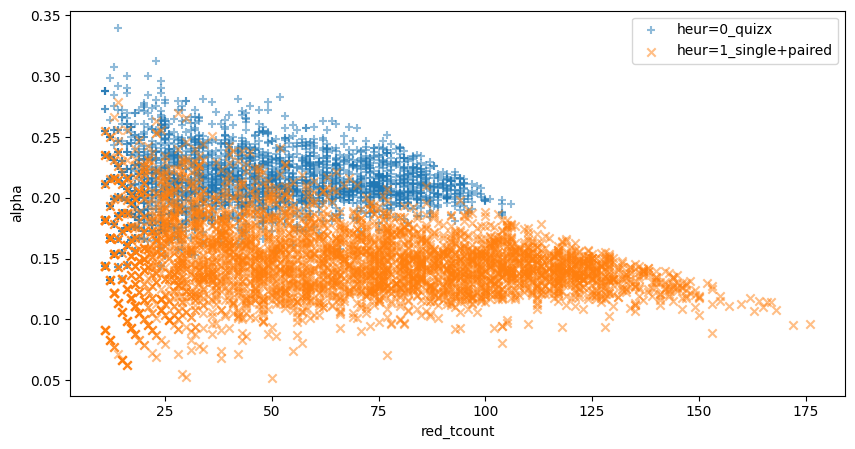

In [8]:
plt.figure(figsize=(10, 5))

max_heurs = 2

for feat, color, marker in zip(sorted(data[feat_name].unique())[:max_heurs], colors, markers):
    data_feat = data[data[feat_name] == feat]
    plt.scatter(data_feat[groupby_data], data_feat['alpha'], label=f'{feat_name}={feat}', alpha=0.5, color=color, marker=marker)

# Set the x-axis label and y-axis label
plt.xlabel(groupby_data)
plt.ylabel('alpha')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [9]:
### Comparison at each size ###
# groupby_data = "max_tcount"
# feat_name = "min_uncut"
data.groupby([groupby_data,feat_name]).agg(
    avg_time=pd.NamedAgg("time", "mean"),
    std_time=pd.NamedAgg("time", np.std),
    med_time=pd.NamedAgg("time", "median"),
    avg_a=pd.NamedAgg("alpha", "mean"),
    std_a=pd.NamedAgg("alpha", np.std),
    med_a=pd.NamedAgg("alpha", "median"),
)

/var/folders/jj/chbmjhbd5gbd4f05m1x14ld80000gn/T/ipykernel_2293/1834889147.py:4: FutureWarning: The provided callable <function std at 0x1068b0ea0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  data.groupby([groupby_data,feat_name]).agg(


avg_time  std_time  med_time     avg_a  \
red_tcount heur                                                          
11         0_quizx              5.295455  7.831301       2.0  0.222869   
           1_single+paired      5.159091  7.929759       2.0  0.165165   
           2_single             5.136364  8.056749       2.0  0.182410   
12         0_quizx              4.232558  4.824724       2.0  0.206971   
           1_single+paired      4.046512  4.628861       2.0  0.158184   
...                                  ...       ...       ...       ...   
166        1_single+paired  51489.000000       NaN   51489.0  0.113930   
167        1_single+paired  52469.000000       NaN   52469.0  0.114296   
168        1_single+paired  30889.000000       NaN   30889.0  0.107846   
172        1_single+paired  13524.000000       NaN   13524.0  0.095089   
176        1_single+paired  25879.000000       NaN   25879.0  0.096294   

                               std_a     med_a  
red_tcount heur                                 
11         0_quizx          0.036890  0.223041  
           1_single+paired  0.047164  0.181818  
           2_single         0.045617  0.181818  
12         0_quizx          0.039479  0.215414  
           1_single+paired  0.041824  0.166667  
...                              ...       ...  
166        1_single+paired       NaN  0.113930  
167        1_single+paired       NaN  0.114296  
168        1_single+paired       NaN  0.107846  
172        1_single+paired       NaN  0.095089  
176        1_single+paired       NaN  0.096294  

[365 rows x 6 columns]

<Axes: xlabel='Number of qubits, T-count', ylabel='Mean Log Time'>

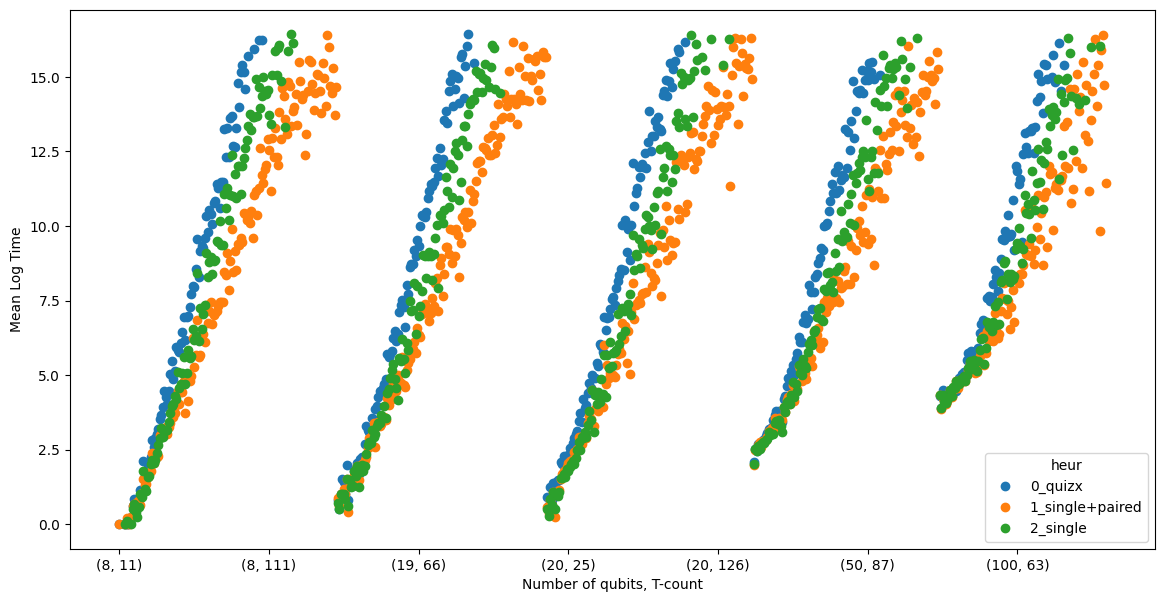

In [10]:
### Plot (No. of Gates vs. Average Simulation Time) ###
data.groupby(["qs", groupby_data,feat_name]).mean().unstack()["log2_time"].plot(
    xlabel="Number of qubits, T-count", 
    ylabel="Mean Log Time",
    marker="o",
    linestyle="None",
    figsize=(14, 7)
)

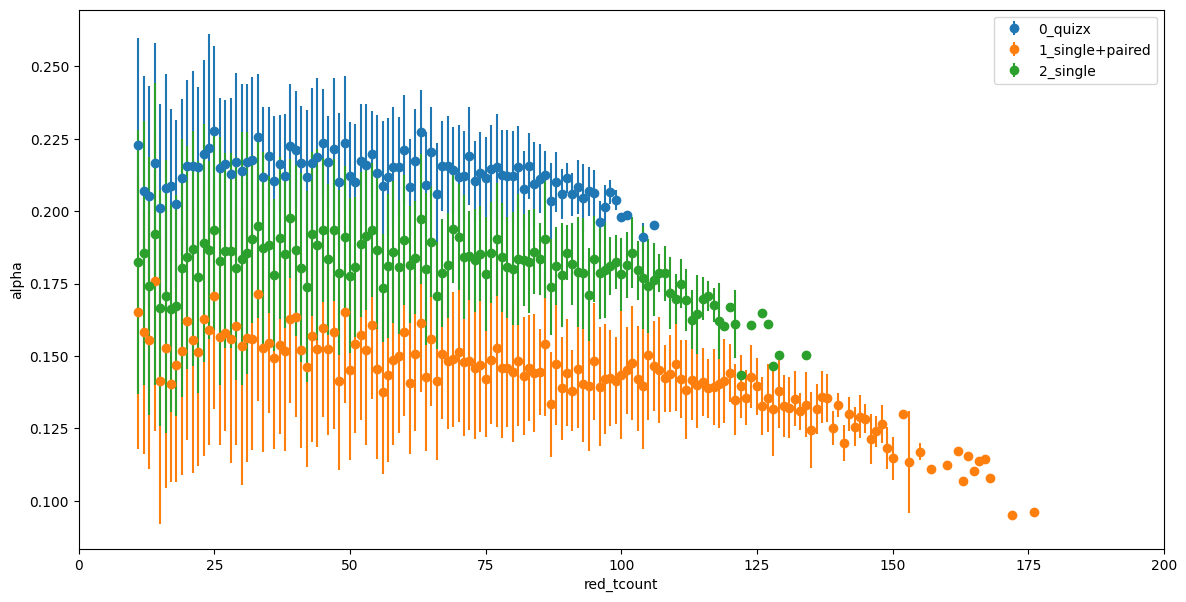

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

metric = efficiency

# Drop NaN values from the data
grouped_data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=[metric])
max_x_grouped = 0
min_x_grouped = np.inf

# Get unique feat_name values
unique_feats = grouped_data[feat_name].unique()

# unique_feats = (MAIN_DATA,)

# Plot each line for each feat_name value
plt.figure(figsize=(14, 7))

for feat, color in zip(unique_feats, colors):
    # Filter data for the current feat_name
    feat_data = grouped_data[grouped_data[feat_name] == feat]
    # print(feat_data.head())
    
    # Extract x and y values for the current feat_name
    x = feat_data[groupby_data].values
    y = feat_data[metric].values


    # Group by the specified column and calculate mean and standard deviation
    mean_data = feat_data.groupby(groupby_data)[metric].mean()
    std_data = feat_data.groupby(groupby_data)[metric].std()

    # Extract x values (groupby_data) and y values (mean of metric)
    x_grouped = mean_data.index.values
    y_grouped = mean_data.values
    yerr = std_data.values

    # 6-qubit hidden shift
    if type(unique_feats) == tuple and unique_feats == (MAIN_DATA,):
        x = np.log2(x)
        x_grouped = np.log2(x_grouped)
        color = colors[1]

    # Fit a line to the data
    slope, intercept = np.polyfit(x, y, 1)
    y_fit = slope * x + intercept

    # x = feat_data[groupby_data].values
    # Calculate the confidence interval
    n = len(x)
    t = stats.t.ppf(1 - 0.025, n - 2)  # 95% confidence interval
    residuals = y - y_fit
    std_err = np.sqrt(np.sum(residuals**2) / (n - 2))
    conf_interval = t * std_err * np.sqrt(1/n + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

    # Ensure x-values are unique for fill_between
    unique_x, unique_indices = np.unique(x, return_index=True)
    y_fit_unique = y_fit[unique_indices]
    conf_interval_unique = conf_interval[unique_indices]

    # if 'log' not in metric or circ == "iqp":
    plt.errorbar(x_grouped, y_grouped, yerr=yerr, fmt='o', label=feat, color=color)
        # if circ == "iqp":
        #     plt.plot(x, y_fit, label=f'Fitted line ({feat}, slope = {slope:.5f})', color=color)
            
    # else:
    # Plot the data and the fitted line
    # plt.plot(x, y, 'o', label=f'{feat}', color=color)
    
    if 'log' in metric:
        plt.plot(x, y_fit, label=f'Fitted line ({feat}, slope = {slope:.5f})', color=color)
        plt.fill_between(unique_x, y_fit_unique - conf_interval_unique, y_fit_unique + conf_interval_unique, color=color, alpha=0.2, label=f'95% CI ({feat})')

    max_x_grouped = max(max_x_grouped, max(x_grouped))
    min_x_grouped = min(min_x_grouped, min(x_grouped))

# Add labels and legend
plt.xlabel(groupby_data)
if type(unique_feats) == tuple and unique_feats == (MAIN_DATA,):
    plt.xlabel(f"log {groupby_data}")
plt.ylabel(metric)
plt.legend()

if max_x_grouped > 100:
    min_x_grouped = 0
    max_x_grouped = np.ceil(max_x_grouped / 50) * 50

# Set x-axis to only show integer labels
plt.xticks(np.arange(min_x_grouped, max_x_grouped + 1, max(1, (max_x_grouped - min_x_grouped) // 8)))

plt.show()

In [12]:
grouped_data

,qs,depth,tcount,red_tcount,seed,terms,time,alpha,heur,log2_terms,log2_time,beta
8555,100,140,501,63,7642,22618,2634,0.229606,0_quizx,14.465184,11.363040,0.144652
8162,8,25,145,43,572,143,11,0.166509,0_quizx,7.159871,3.459432,0.894984
8161,8,16,65,22,4916,21,1,0.199651,0_quizx,4.392317,0.000000,0.549040
8160,100,120,598,33,5178,265,50,0.243935,0_quizx,8.049849,5.643856,0.080498
8159,8,34,172,94,4221,334169,16077,0.195215,0_quizx,18.350218,13.972711,2.293777
...,...,...,...,...,...,...,...,...,...,...,...,...
12993,100,120,598,33,5178,79,24,0.191024,2_single,6.303781,4.584963,0.063038
12992,8,34,172,94,4221,33713,2218,0.160011,2_single,15.041017,11.115044,1.880127
12990,100,113,415,33,6421,61,24,0.179719,2_single,5.930737,4.584963,0.059307
12994,8,16,65,22,4916,13,1,0.168202,2_single,3.700440,0.000000,0.462555


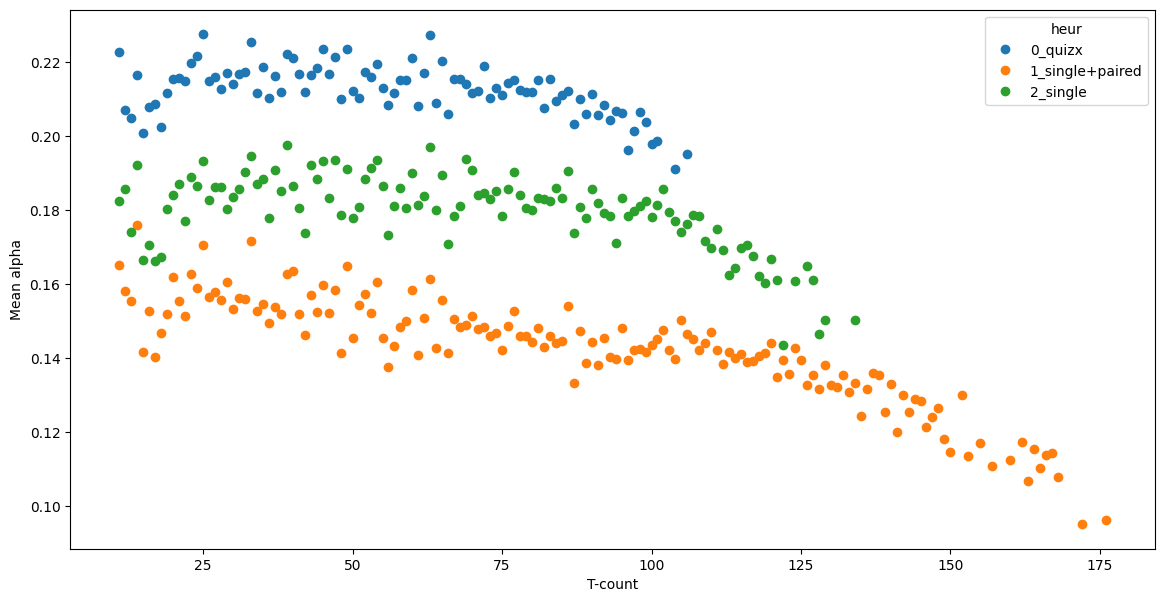

In [13]:
### Plot (No. of Gates vs. Average Simulation Time) ###
ax = data.groupby([groupby_data,feat_name]).mean().unstack()[efficiency].plot(
    xlabel="T-count", 
    ylabel=f"Mean {efficiency}",
    marker="o",
    linestyle="None",
    figsize=(14, 7),
)

# Set x-axis to only show integer labels and limit the number of labels
# x_values = ax.get_xticks()
# x_values = np.round(x_values).astype(int)

# min_x_values = max(x_values.min(), 0) 
# max_x_values = x_values.max()

# print(min_x_values, max_x_values)


# if max_x_values > 100:
#     min_x_values = 0
#     max_x_values = np.ceil(max_x_values / 50) * 50
#     max_x_values = max_x_values.astype(int)

# ax.set_xticklabels(np.arange(min_x_values, max_x_values + 1, max(1, (max_x_values - min_x_values) // 8)))



qs   red_tcount  heur           
8    11          0_quizx             0.000000
                 1_single+paired     0.000000
                 2_single                -inf
     12          0_quizx                 -inf
                 1_single+paired         -inf
                                      ...    
100  128         2_single           16.036517
     133         1_single+paired    15.903858
     134         1_single+paired    16.408894
     149         1_single+paired    14.717248
     153         1_single+paired    11.445532
Name: log2_time, Length: 1610, dtype: float64


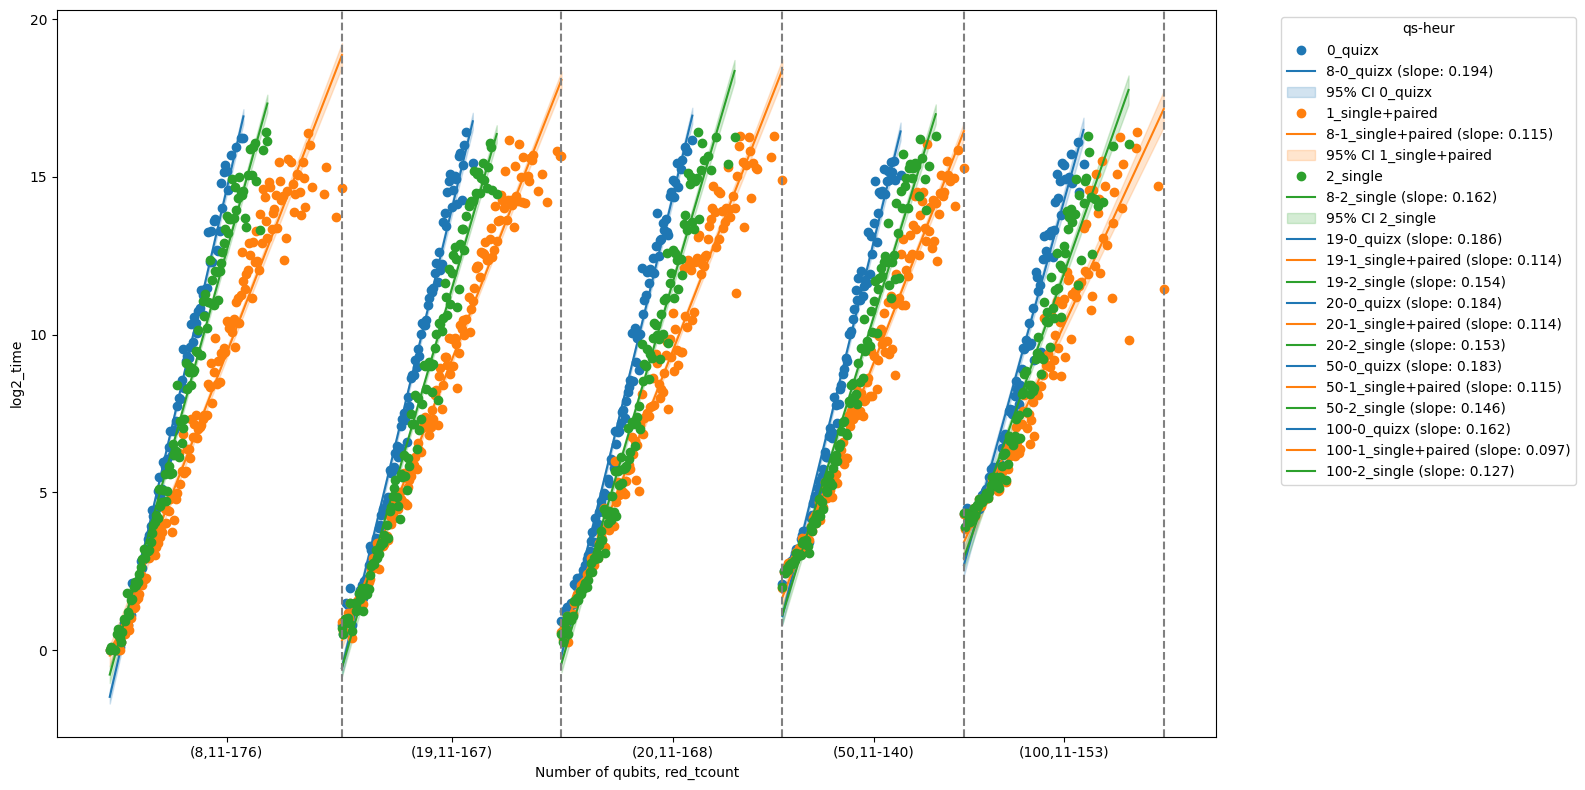

In [14]:
import numpy as np
import matplotlib.pyplot as plt

metric = "log2_time"

# Assuming 'data' is your DataFrame and 'groupby_data' and 'feat_name' are your column names
if groupby_data != "qs":
    grouped_data = data.groupby(["qs", groupby_data, feat_name])
    # Calculate mean
    mean_data = grouped_data.mean()[metric]
else:
    mean_data = data.reset_index().set_index([groupby_data, feat_name])[metric]

# print(grouped_data.agg()[metric])

print(mean_data)


# print(mean_data.index.names)


# Ensure mean_data has a MultiIndex
if not isinstance(mean_data.index, pd.MultiIndex):
    raise TypeError("Index must be a MultiIndex")

# Print the unique values for each level of the MultiIndex
# print("Unique values for 'qs':", mean_data.index.get_level_values('qs').unique())
# print(f"Unique values for '{feat_name}':", mean_data.index.get_level_values(feat_name).unique())

# Plot with error bars
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the mean data for each pair (qs, feat_name)
if groupby_data != "qs":
    qs_values = mean_data.index.get_level_values('qs').unique()
else:
    qs_values = []
feat_names = mean_data.index.get_level_values(feat_name).unique()


cur_index = 0

num_values_list = []


for i in range(len(qs_values)):
    qs = qs_values[i]
    num_values = 0
    min_value = np.inf
    max_value = 0
    for feat, color in zip(feat_names, colors):
        try:
            mean_data_pair = mean_data.xs((qs, feat), level=('qs', feat_name))        
        except KeyError:
            print(qs, feat)
            # Handle cases where the combination of qs and feat_name does not exist
            continue

        
        # drop inf values
        mean_data_pair = mean_data_pair.replace([np.inf, -np.inf], np.nan).dropna()
        if mean_data_pair.empty:
            continue

        groupby_data_values = sorted(mean_data_pair.index.get_level_values(groupby_data).unique())
        num_values = max(num_values, len(groupby_data_values))
        min_value = min(min_value, min(groupby_data_values))
        max_value = max(max_value, max(groupby_data_values))    

        x_values = [cur_index + x - min(groupby_data_values) for x in groupby_data_values]
        y_values = mean_data_pair.values.flatten()

        # print(x_values)
        # print(y_values)
        

        ax.plot(
            x_values,
            y_values,
            marker="o",
            linestyle="None",
            color=color,
            label= f'{feat}' if i == 0 else ''
        )

        if metric == "alpha":
            continue

        # Fit a linear regression model to find the slope for each pair (qs, feat_name)
        x = np.array(groupby_data_values)
        y = mean_data_pair.values.flatten()
        slope, intercept = np.polyfit(x, y, 1)
        y_fit = slope * x + intercept

        # Calculate the confidence interval
        n = len(x)
        t = stats.t.ppf(1 - 0.025, n - 2)  # 95% confidence interval
        residuals = y - y_fit
        std_err = np.sqrt(np.sum(residuals**2) / (n - 2))
        conf_interval = t * std_err * np.sqrt(1/n + (x - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

        # print(type(x[0]))

        if np.isnan(slope):
            print(f"Slope is NaN for qs: {qs}, feat: {feat}")
            print(mean_data_pair)
        
        
        # Plot the linear regression line
        ax.plot(x_values, y_fit, linestyle='-', label=f'{qs}-{feat} (slope: {slope:.3f})', color=color)
        ax.fill_between(x_values, y_fit - conf_interval, y_fit + conf_interval, color=color, alpha=0.2,
                        label=f'95% CI {feat}' if i == 0 else '')



    num_values_list.append((qs,  min_value, max_value))
    cur_index += max_value - min_value

cur_index = 0

tick_positions = []
tick_labels = []

for (qs, min_value, max_value) in num_values_list:
    range_value = max_value - min_value
    cur_index += range_value
    ax.axvline(x=cur_index, color='gray', linestyle='--')
    tick_positions.append(cur_index - range_value // 2)
    tick_labels.append(f'({qs},{min_value}-{max_value})')
   

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)

plt.ylabel(metric)
plt.xlabel(f'Number of qubits, {groupby_data}')

plt.legend(title=f'qs-{feat_name}', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

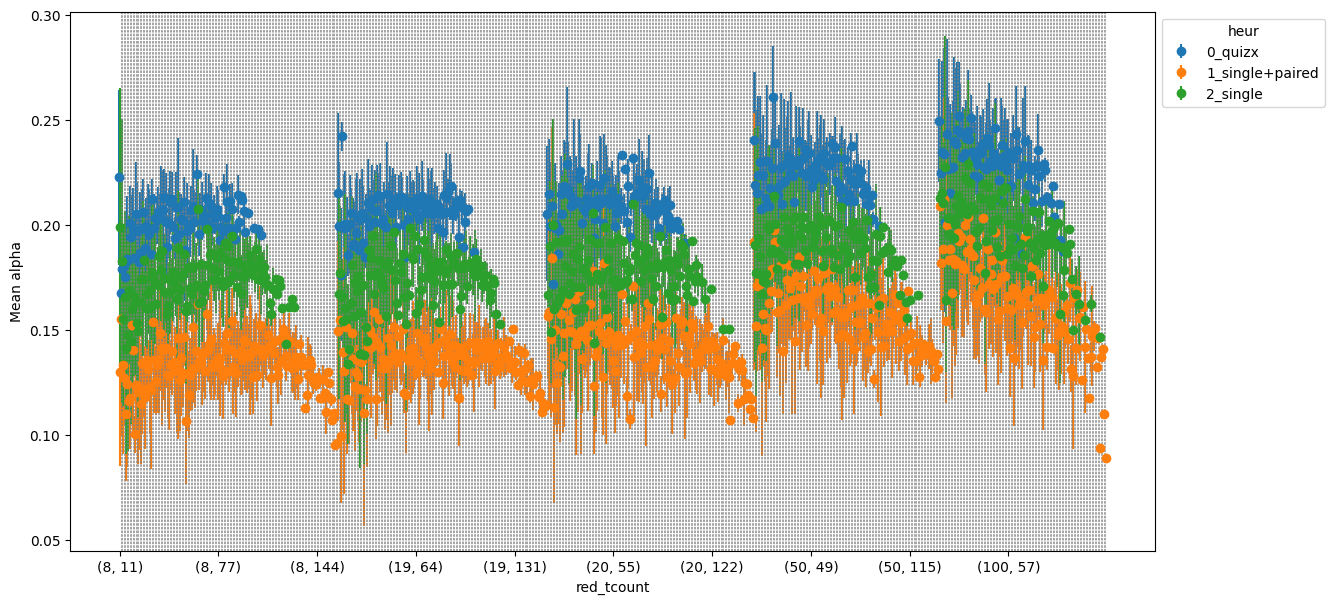

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# efficiency = "alpha"


# Assuming 'data' is your DataFrame and 'groupby_data' and 'feat_name' are your column names
if groupby_data != "qs":
    # efficiency = "alpha"
    grouped_data = data.groupby(["qs",groupby_data, feat_name])
else:
    # efficiency = "beta"
    grouped_data = data.groupby([groupby_data, feat_name])



# Calculate mean and standard deviation
mean_data = grouped_data.mean().unstack()[efficiency]
std_data = grouped_data.std().unstack()[efficiency]

# Plot with error bars
fig, ax = plt.subplots(figsize=(14, 7))

# Number of groups
n_groups = len(mean_data.columns)

# Width of each bar
bar_width = 0.8 / n_groups

# Positions of the bars
indices = np.arange(len(mean_data))

overlap = False

for i, (col, color) in enumerate(zip(mean_data.columns, colors)):
    if overlap:
        i = (n_groups - 1) / 2
    ax.errorbar(
        indices + i * bar_width,
        mean_data[col],
        yerr=std_data[col],
        fmt='o',
        label=col,
        color=color,
        linestyle='None'
    )

ax.set_xlabel(f"{groupby_data}")
ax.set_ylabel(f"Mean {efficiency}")
# Reduce the number of x-ticks
step = max(1, len(mean_data) // 10)  # Show at most 10 x-ticks
ax.set_xticks(indices[::step] + bar_width * (n_groups - 1) / 2)
ax.set_xticklabels(mean_data.index[::step])

# Draw dashed lines between each group
for idx in indices[1:]:
    ax.axvline(x=idx - bar_width * 0.75 , color='gray', linestyle='--', linewidth=0.5)

ax.legend(title=feat_name, loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

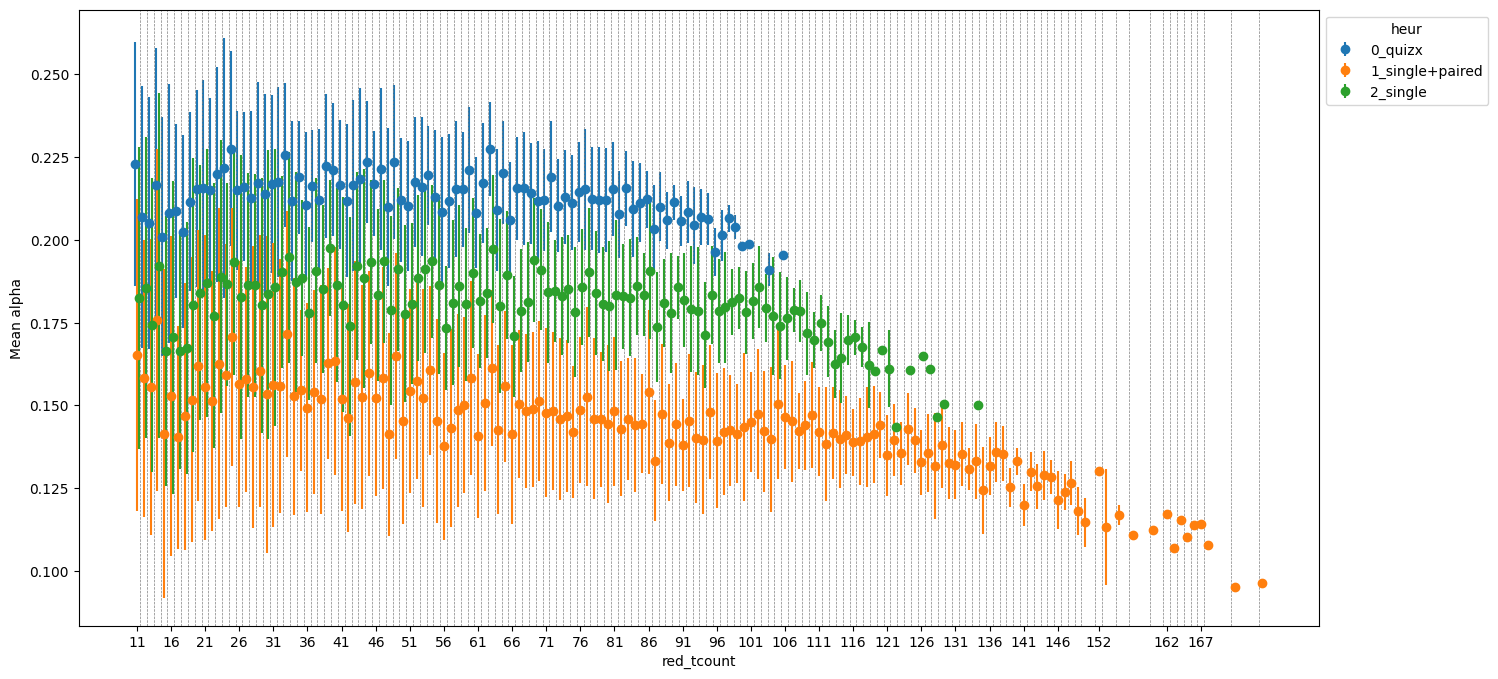

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

metric = "alpha"

# Assuming 'data' is your DataFrame and 'groupby_data' and 'feat_name' are your column names
grouped_data = data.groupby([groupby_data, feat_name])

# Calculate mean and standard deviation
mean_data = grouped_data.mean().unstack()[metric]
std_data = grouped_data.std().unstack()[metric]

# print(mean_data.idxmax())

# Plot with error bars
fig, ax = plt.subplots(figsize=(16, 8))

# Number of groups
n_groups = len(mean_data.columns)

# Width of each bar
bar_width = 0.8 / n_groups


# Positions of the bars
indices = mean_data.index - mean_data.index.min()

for i, (col, color) in enumerate(zip(mean_data.columns, colors)):
    ax.errorbar(
        indices + i * bar_width,
        mean_data[col],
        yerr=std_data[col],
        fmt='o',
        label=col,
        color=color,
        linestyle='None'
    )

for i in indices[1:]:
    ax.axvline(x=i - bar_width , color='gray', linestyle='--', linewidth=0.5)


ax.set_xlabel(groupby_data)
ax.set_ylabel(f"Mean {metric}")
# Reduce the number of x-ticks
n = 30
step = max(1, len(mean_data) // n)  # Show at most n x-ticks
ax.set_xticks(indices[::step] + bar_width * (n_groups - 1) / 2)
ax.set_xticklabels(mean_data.index[::step])
ax.legend(title=feat_name, loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

<Axes: xlabel='T-count', ylabel='Mean alpha'>

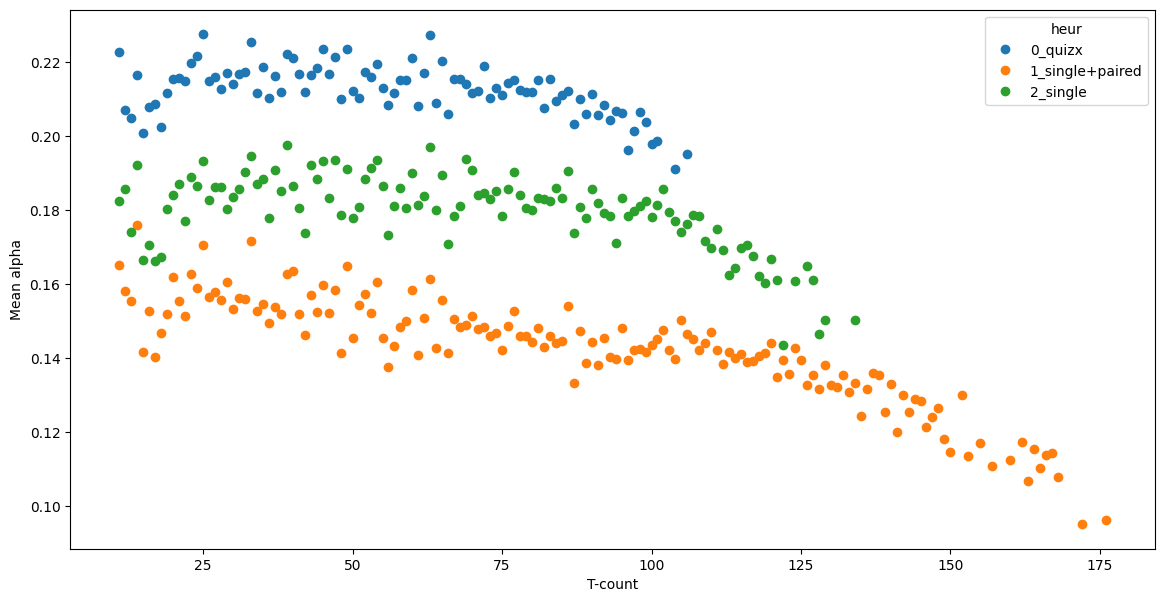

In [17]:
### Plot (No. of Gates vs. Average Simulation Time) ###
data.groupby([groupby_data,feat_name]).mean().unstack()["alpha"].plot(
    xlabel="T-count", 
    ylabel="Mean alpha",
    marker="o",
    linestyle="None",
    figsize=(14, 7)
)

<Axes: xlabel='T-count', ylabel='Median alpha'>

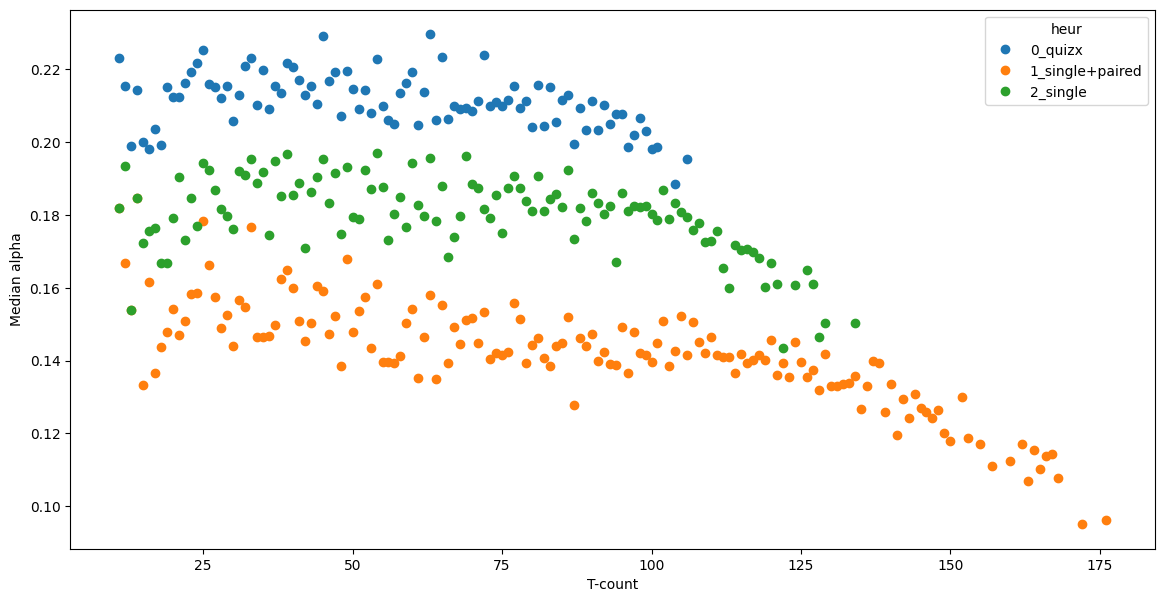

In [18]:
### Plot (No. of Gates vs. Average Simulation Time) ###
data.groupby([groupby_data,feat_name]).median().unstack()["alpha"].plot(
    xlabel="T-count", 
    ylabel="Median alpha",
    marker="o",
    linestyle="None",
    figsize=(14, 7)
)

<Axes: xlabel='T-count', ylabel='Mean Log terms'>

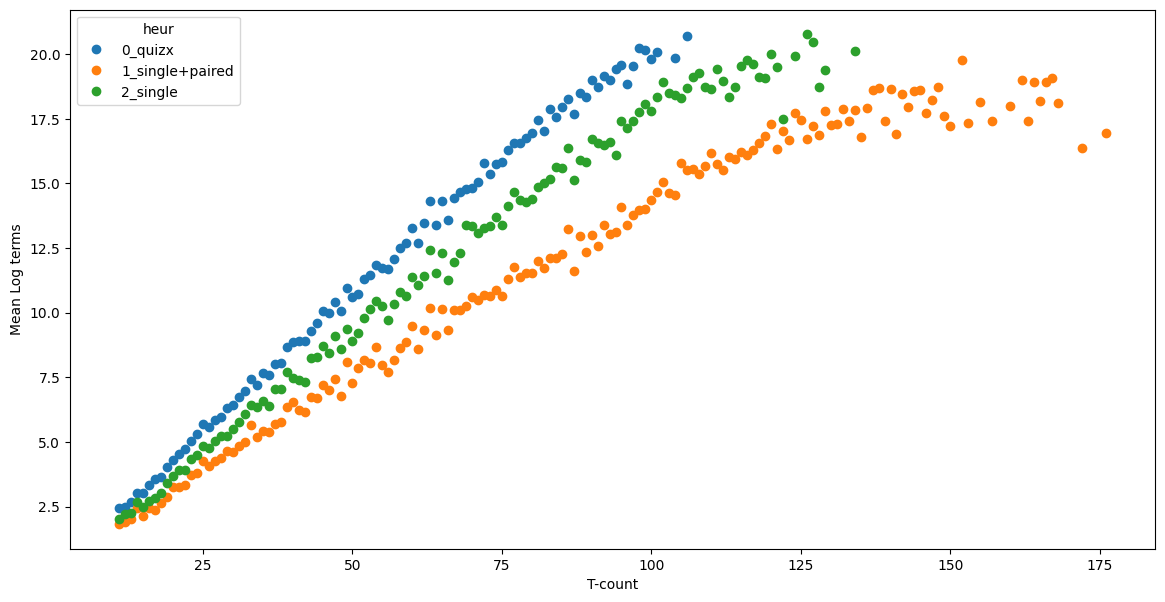

In [19]:
### Plot (No. of Gates vs. Average Simulation Time) ###
data.groupby([groupby_data,feat_name]).mean().unstack()["log2_terms"].plot(
    xlabel="T-count", 
    ylabel="Mean Log terms",
    marker="o",
    linestyle="None",
    figsize=(14, 7)
)

<Axes: xlabel='Number of qubits, T-count', ylabel='Mean Log terms'>

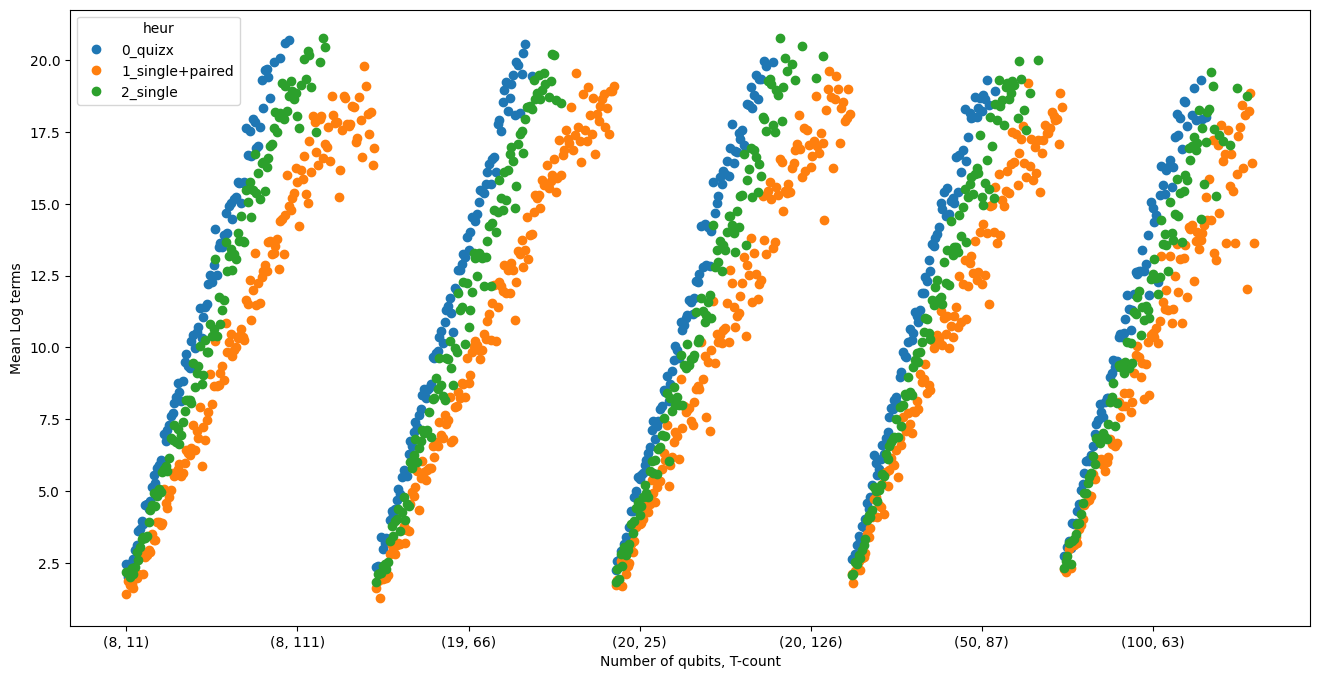

In [20]:
### Plot (No. of Gates vs. Average Simulation Time) ###
data.groupby(["qs", groupby_data,feat_name]).mean().unstack()["log2_terms"].plot(
    xlabel="Number of qubits, T-count", 
    ylabel="Mean Log terms",
    marker="o",
    linestyle="None",
    figsize=(16,8)
)

<Axes: xlabel='T-count', ylabel='Median Log terms'>

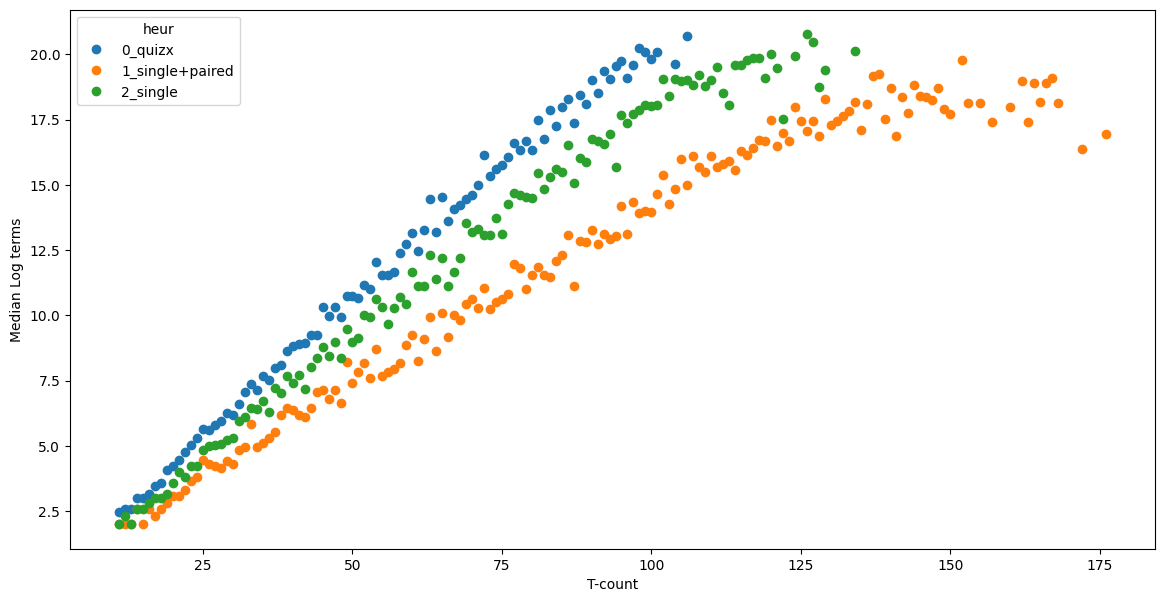

In [21]:
### Plot (No. of Gates vs. Average Simulation Time) ###
data.groupby([groupby_data,feat_name]).median().unstack()["log2_terms"].plot(
    xlabel="T-count", 
    ylabel="Median Log terms",
    marker="o",
    linestyle="None",
    figsize=(14, 7)
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


      qs  depth  tcount  red_tcount  seed  terms  time     alpha  \
7965   8     10      63          14   271      6     1  0.184640   
1937   8     10      63          14   271      3     0  0.113212   
7333   8     10      35          12  9770      6     0  0.215414   
1096   8     10      35          12  9770      2     0  0.083333   
8721   8     13      50          11   130      3     1  0.144088   

                 heur  log2_terms  log2_time     beta  
7965          0_quizx    2.584963        0.0  0.32312  
1937  1_single+paired    1.584963       -inf  0.19812  
7333          0_quizx    2.584963       -inf  0.32312  
1096  1_single+paired    1.000000       -inf  0.12500  
8721          0_quizx    1.584963        0.0  0.19812  


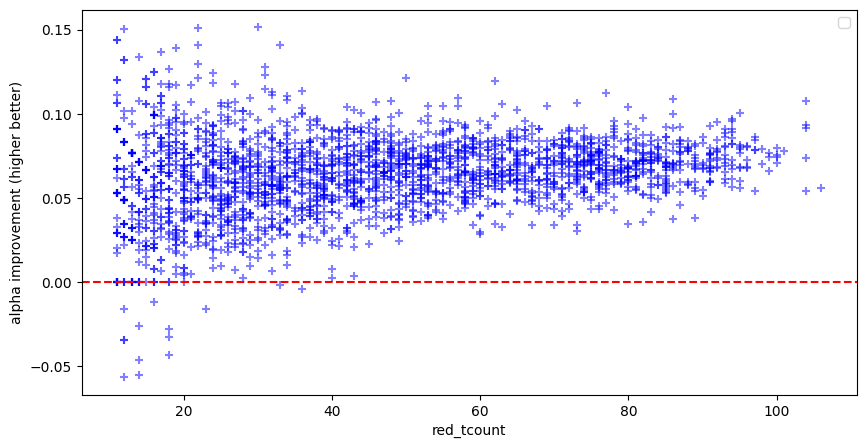

In [22]:
diff_df = data.copy()


data_ignored = SIDE_DATA
data_used = OG_DATA
if circ == "iqp":
    data_ignored, data_used = data_used, data_ignored

if diff_df[feat_name].unique().size > 2:
    diff_df = diff_df[diff_df[feat_name] != data_ignored]

if "depth" in diff_df.columns:
    diff_df.sort_values(["qs","depth","seed", feat_name], inplace=True)
    is_paired = diff_df[["qs", "depth","seed"]].duplicated(keep=False)
else:
    diff_df.sort_values(["qs","seed", feat_name], inplace=True)
    is_paired = diff_df[["qs","seed"]].duplicated(keep=False)
single_df = diff_df[~is_paired]
diff_df = diff_df[is_paired]


# diff_df = diff_df.set_index(["qs","seed"])
# diff_df["alpha_diff"] = diff_df.groupby(["qs","seed"], as_index=False)["alpha"].apply(lambda x: x.diff(1))
print(diff_df.head())
# print(len(diff_df[ (diff_df["qs"] == 50)]))
diff_df[f"{efficiency}_diff"] = -diff_df.groupby(diff_df[feat_name].eq(data_used).cumsum())[efficiency].diff()
# print(diff_df[ ["alpha_diff","alpha"]].head(100))
diff_df = diff_df.dropna()


plt.figure(figsize=(10, 5))


# Plot the data with translucent points
plt.scatter(diff_df[groupby_data], diff_df[f'{efficiency}_diff'], color='blue', alpha=0.5, marker='+')

# Set the x-axis label and y-axis label
plt.xlabel(groupby_data)
plt.ylabel(f'{efficiency} improvement (higher better)')

# Add a legend
plt.legend()

plt.axhline(y=0, color='r', linestyle='--')  # Adds a dashed line at y=0

# Show the plot
plt.show()

In [23]:
single_df.head(100)

,qs,depth,tcount,red_tcount,seed,terms,time,alpha,heur,log2_terms,log2_time,beta
4978,8,40,193,108,596,7774,965,0.119671,1_single+paired,12.924441,9.914385,1.615555
3502,8,40,252,106,801,98246,9049,0.156454,1_single+paired,16.584111,13.143543,2.073014
6070,8,40,188,98,3152,8470,908,0.133144,1_single+paired,13.048146,9.826548,1.631018
4759,8,40,212,106,4221,31612,3551,0.141021,1_single+paired,14.948185,11.794010,1.868523
5363,8,43,222,109,596,15732,1575,0.127903,1_single+paired,13.941414,10.621136,1.742677
...,...,...,...,...,...,...,...,...,...,...,...,...
490,8,50,192,112,7887,6542,961,0.113174,1_single+paired,12.675516,9.908393,1.584440
5330,8,50,236,118,7945,68179,6797,0.136077,1_single+paired,16.057040,12.730682,2.007130
5676,8,50,172,90,8196,2086,337,0.122517,1_single+paired,11.026523,8.396605,1.378315
5128,8,50,247,96,8351,9145,1203,0.137070,1_single+paired,13.158767,10.232421,1.644846


In [24]:
print(len(single_df))

1226


In [25]:
metric = f"{efficiency}_diff"
n1 = 5e-5
n2 = 1e-4

# Define an improvement as a positive value in metric
diff_df['%_improve'] = diff_df[metric] < 0
diff_df[f'%_improve_{n1}'] = diff_df[metric] < -n1
diff_df[f'%_improve_{n2}'] = diff_df[metric] < -n2
diff_df['%_deprove'] = diff_df[metric] > 0
diff_df[f'%_deprove_{n1}'] = diff_df[metric] > n1
diff_df[f'%_deprove_{n2}'] = diff_df[metric] > n2

# Group by 'max_tcount' and calculate the proportion of improvements
improvement_proportion = diff_df.groupby(groupby_data)['%_improve'].mean()
# Count the number of rows for each max_tcount value
count_df = diff_df[groupby_data].value_counts().reset_index(name='count').rename(columns={'index': groupby_data})
# Group by 'max_tcount' and calculate the proportion of improvements
improvement_proportion_5 = diff_df.groupby(groupby_data)[f'%_improve_{n1}'].mean()
improvement_proportion_1 = diff_df.groupby(groupby_data)[f'%_improve_{n2}'].mean()
# Count the number of rows for each max_tcount value
# count_df_5 = diff_df[groupby_data].value_counts().reset_index(name='count_5').rename(columns={'index': groupby_data})
# print(count_df_5.head())
# print(count_df.head())
deprovement_proportion = diff_df.groupby(groupby_data)['%_deprove'].mean()
deprovement_proportion_5 = diff_df.groupby(groupby_data)[f'%_deprove_{n1}'].mean()
deprovement_proportion_1 = diff_df.groupby(groupby_data)[f'%_deprove_{n2}'].mean()


prop_df = pd.merge(improvement_proportion, improvement_proportion_5, on=groupby_data)
prop_df = pd.merge(prop_df, improvement_proportion_1, on=groupby_data)

deprop_df = pd.merge(deprovement_proportion, deprovement_proportion_5, on=groupby_data)
deprop_df = pd.merge(deprop_df, deprovement_proportion_1, on=groupby_data)
# pcount_df = pd.merge(count_df, count_df_5, on=groupby_data)

# prop_df = pd.merge(prop_df, deprop_df, on=groupby_data)
prop_df = pd.merge(prop_df, count_df, on=groupby_data)
deprop_df = pd.merge(deprop_df, count_df, on=groupby_data)
print(prop_df.head(20))
print("overall proportion improve: ", diff_df["%_improve"].mean())
print("overall proportion deprove: ", diff_df["%_deprove"].mean())
print(f"overall proportion improve >{n1}: ", diff_df[f'%_improve_{n1}'].mean())
print(f"overall proportion deprove >{n1}: ", diff_df[f"%_deprove_{n1}"].mean())
print(f"overall proportion improve >{n2}: ", diff_df[f'%_improve_{n2}'].mean())
print(f"overall proportion deprove >{n2}: ", diff_df[f"%_deprove_{n2}"].mean())

    red_tcount  %_improve  %_improve_5e-05  %_improve_0.0001  count
0           11   0.000000         0.000000          0.000000     44
1           12   0.093023         0.093023          0.093023     43
2           13   0.000000         0.000000          0.000000     39
3           14   0.090909         0.090909          0.090909     33
4           15   0.000000         0.000000          0.000000     36
5           16   0.021277         0.021277          0.021277     47
6           17   0.000000         0.000000          0.000000     42
7           18   0.063830         0.063830          0.063830     47
8           19   0.000000         0.000000          0.000000     35
9           20   0.000000         0.000000          0.000000     52
10          21   0.000000         0.000000          0.000000     26
11          22   0.000000         0.000000          0.000000     35
12          23   0.029412         0.029412          0.029412     34
13          24   0.000000         0.000000      

In [26]:
print(prop_df[prop_df["%_improve"] > 0])

    red_tcount  %_improve  %_improve_5e-05  %_improve_0.0001  count
1           12   0.093023         0.093023          0.093023     43
3           14   0.090909         0.090909          0.090909     33
5           16   0.021277         0.021277          0.021277     47
7           18   0.063830         0.063830          0.063830     47
12          23   0.029412         0.029412          0.029412     34
22          33   0.029412         0.029412          0.029412     34
25          36   0.028571         0.028571          0.028571     35


In [27]:
print(deprop_df[deprop_df["%_deprove"] > 0])

    red_tcount  %_deprove  %_deprove_5e-05  %_deprove_0.0001  count
0           11   0.818182         0.818182          0.818182     44
1           12   0.837209         0.837209          0.837209     43
2           13   0.846154         0.846154          0.846154     39
3           14   0.787879         0.787879          0.787879     33
4           15   0.972222         0.972222          0.972222     36
..         ...        ...              ...               ...    ...
88          99   1.000000         1.000000          1.000000      3
89         100   1.000000         1.000000          1.000000      4
90         101   1.000000         1.000000          1.000000      1
91         104   1.000000         1.000000          1.000000      5
92         106   1.000000         1.000000          1.000000      1

[93 rows x 5 columns]


In [28]:
### Best Improvement and Worst Loss ###
t_df = diff_df.copy()
# t_df = t_df[t_df["alpha_diff"].abs() > 1e-5]
t_df = t_df.groupby([ "qs",groupby_data,"seed",feat_name]).mean().unstack()[f"{efficiency}_diff"]
# print(t_df.head())
t_df.loc[:, "diff"] = t_df[MAIN_DATA]
t_df[["diff"]].groupby(["qs",groupby_data]).agg(
    best_improvement=pd.NamedAgg("diff", "max"),
    worst_loss=pd.NamedAgg("diff", "min"),
    avg_diff=pd.NamedAgg("diff", "mean"),
    std_diff=pd.NamedAgg("diff", np.std),
)

/var/folders/jj/chbmjhbd5gbd4f05m1x14ld80000gn/T/ipykernel_2293/4293816942.py:7: FutureWarning: The provided callable <function std at 0x1068b0ea0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  t_df[["diff"]].groupby(["qs",groupby_data]).agg(


best_improvement  worst_loss  avg_diff  std_diff
qs  red_tcount                                                  
8   11                  0.144088    0.053179  0.094598  0.036822
    12                  0.132081   -0.056506  0.012596  0.066451
    13                  0.076923    0.000000  0.045626  0.035147
    14                  0.087313    0.000000  0.053398  0.035142
    15                  0.120490    0.021462  0.065611  0.044427
...                          ...         ...       ...       ...
100 87                  0.077098    0.077098  0.077098       NaN
    88                  0.057583    0.057583  0.057583       NaN
    92                  0.095241    0.095241  0.095241       NaN
    93                  0.075521    0.075521  0.075521       NaN
    96                  0.067568    0.067568  0.067568       NaN

[428 rows x 4 columns]

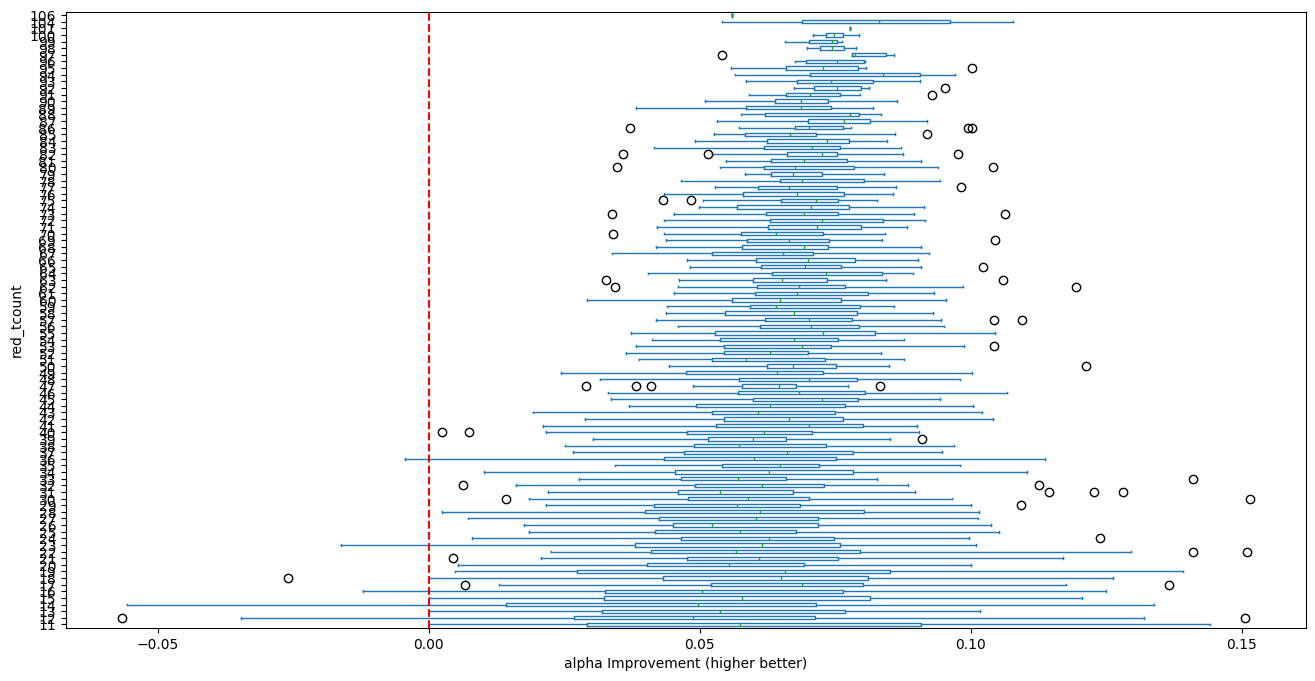

In [29]:
box_df = t_df.groupby(["qs","seed", groupby_data]).mean().unstack()["diff"]
box_df.plot.box(
    xlabel=f"{efficiency} Improvement (higher better)",
    ylabel=groupby_data,
    vert=False,
    figsize=(16, 8),
).axvline(x=0, color='r', linestyle='--')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


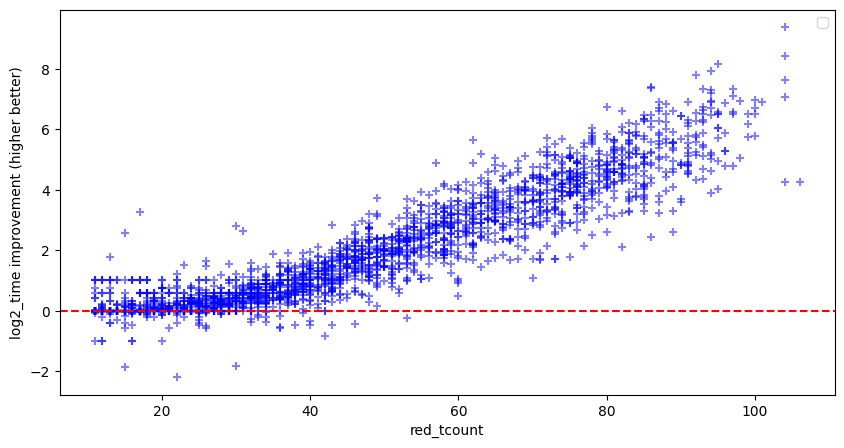

In [30]:
metric = "log2_time"
diff_df = data.copy()


data_ignored = SIDE_DATA
data_used = OG_DATA
if circ == "iqp":
    data_ignored, data_used = data_used, data_ignored

if diff_df[feat_name].unique().size > 2:
    diff_df = diff_df[diff_df[feat_name] != data_ignored]

# diff_df = diff_df[diff_df["qs"] == 7]
if "depth" in diff_df.columns:
    diff_df.sort_values(["qs","depth","seed", feat_name], inplace=True)
    is_paired = diff_df[["qs", "depth","seed"]].duplicated(keep=False)
else:
    diff_df.sort_values(["qs","seed", feat_name], inplace=True)
    is_paired = diff_df[["qs","seed"]].duplicated(keep=False)
single_df = diff_df[~is_paired]
diff_df = diff_df[is_paired]


# diff_df = diff_df.set_index(["qs","seed"])
# diff_df["alpha_diff"] = diff_df.groupby(["qs","seed"], as_index=False)["alpha"].apply(lambda x: x.diff(1))

# print(len(diff_df[ (diff_df["qs"] == 50)]))
diff_df[f"{metric}_diff"] = -diff_df.groupby(diff_df[feat_name].eq(data_used).cumsum())[metric].diff()
# print(diff_df[ [f"{metric}_diff",metric]].head(100))
diff_df = diff_df.dropna()


plt.figure(figsize=(10, 5))
# Plot the data with translucent points
plt.scatter(diff_df[groupby_data], diff_df[f'{metric}_diff'], color='blue', alpha=0.5, marker='+')

# Set the x-axis label and y-axis label
plt.xlabel(groupby_data)
plt.ylabel(f'{metric} improvement (higher better)')

# Add a legend
plt.legend()

plt.axhline(y=0, color='r', linestyle='--')  # Adds a dashed line at y=0


# Show the plot
plt.show()

In [31]:
### Best Improvement and Worst Loss ###
t_df = diff_df.copy()
# t_df = t_df[t_df["alpha_diff"].abs() > 1e-5]
t_df = t_df.groupby([groupby_data,"seed",feat_name]).mean().unstack()[f"{metric}_diff"]
t_df.loc[:, "diff"] = t_df[MAIN_DATA]
t_df[["diff"]].groupby(groupby_data).agg(
    best_improvement=pd.NamedAgg("diff", "max"),
    worst_loss=pd.NamedAgg("diff", "min"),
    avg_diff=pd.NamedAgg("diff", "mean"),
    std_diff=pd.NamedAgg("diff", np.std),
)

/var/folders/jj/chbmjhbd5gbd4f05m1x14ld80000gn/T/ipykernel_2293/1767562853.py:6: FutureWarning: The provided callable <function std at 0x1068b0ea0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  t_df[["diff"]].groupby(groupby_data).agg(


,best_improvement,worst_loss,avg_diff,std_diff
red_tcount,,,,
11,1.000000,-0.194988,0.121334,0.300430
12,1.000000,-1.000000,0.058000,0.326306
13,1.760812,-inf,-inf,NaN
14,inf,-0.064386,inf,NaN
15,0.761801,-1.874469,0.001862,0.482334
...,...,...,...,...
99,6.174954,6.120112,6.147533,0.038780
100,6.970968,5.790848,6.498463,0.506990
101,6.896703,6.896703,6.896703,NaN


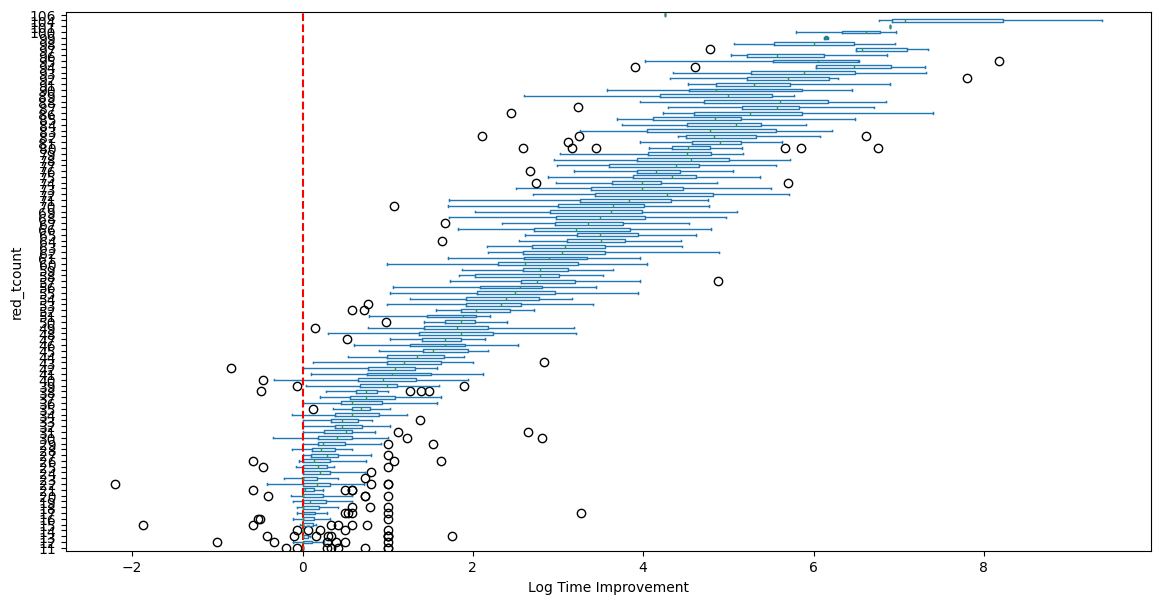

In [32]:
box_df = t_df.groupby(["seed", groupby_data]).mean().unstack()["diff"]
box_df.plot.box(
    xlabel="Log Time Improvement",
    ylabel=groupby_data,
    vert=False,
    figsize=(14, 7),
).axvline(x=0, color='r', linestyle='--')

In [33]:
# metric = "diff"
n1 = 1
n2 = 0.25


# Define an improvement as a positive value in metric
diff_df[f'%_improve_{metric}'] = diff_df[f'{metric}_diff'] < 0
diff_df[f'%_improve_{n1}_{metric}'] = diff_df[f'{metric}_diff'] < -n1
diff_df[f'%_improve_{n2}_{metric}'] = diff_df[f'{metric}_diff'] < -n2
diff_df[f'%_deprove_{metric}'] = diff_df[f'{metric}_diff'] > 0
diff_df[f'%_deprove_{n1}_{metric}'] = diff_df[f'{metric}_diff'] > n1
diff_df[f'%_deprove_{n2}_{metric}'] = diff_df[f'{metric}_diff'] > n2

# print(diff_df[diff_df['red_tcount'] > 40].head(100))

# Group by 'max_tcount' and calculate the proportion of improvements
improvement_proportion = diff_df.groupby(groupby_data)[f'%_improve_{metric}'].mean()
# Group by 'max_tcount' and calculate the proportion of improvements
improvement_proportion_5 = diff_df.groupby(groupby_data)[f'%_improve_{n1}_{metric}'].mean()
improvement_proportion_1 = diff_df.groupby(groupby_data)[f'%_improve_{n2}_{metric}'].mean()
# Count the number of rows for each max_tcount value
count_df = diff_df[groupby_data].value_counts().reset_index(name='count').rename(columns={'index': groupby_data})
# Count the number of rows for each max_tcount value
# count_df_5 = diff_df[groupby_data].value_counts().reset_index(name='count_5').rename(columns={'index': groupby_data})
# print(count_df_5.head())
# print(count_df.head())

# print(diff_df.groupby(groupby_data)['%_improve_1_time'].mean().head())
# print(improvement_proportion_5.head())


prop_df = pd.merge(improvement_proportion, improvement_proportion_5, on=groupby_data)
prop_df = pd.merge(prop_df, improvement_proportion_1, on=groupby_data)
# pcount_df = pd.merge(count_df, count_df_5, on=groupby_data)
prop_df = pd.merge(prop_df, count_df, on=groupby_data)
print(prop_df[prop_df[groupby_data] > 40].head(20))
print("overall proportion improve: ", diff_df[f"%_improve_{metric}"].mean())
print("overall proportion deprove: ", diff_df[f"%_deprove_{metric}"].mean())
print(f"overall proportion improve >{n1}: ", diff_df[f'%_improve_{n1}_{metric}'].mean())
print(f"overall proportion deprove >{n1}: ", diff_df[f"%_deprove_{n1}_{metric}"].mean())
print(f"overall proportion improve >{n2}: ", diff_df[f'%_improve_{n2}_{metric}'].mean())
print(f"overall proportion deprove >{n2}: ", diff_df[f"%_deprove_{n2}_{metric}"].mean())

    red_tcount  %_improve_log2_time  %_improve_1_log2_time  \
30          41             0.000000                    0.0   
31          42             0.028571                    0.0   
32          43             0.028571                    0.0   
33          44             0.000000                    0.0   
34          45             0.000000                    0.0   
35          46             0.024390                    0.0   
36          47             0.000000                    0.0   
37          48             0.000000                    0.0   
38          49             0.000000                    0.0   
39          50             0.000000                    0.0   
40          51             0.000000                    0.0   
41          52             0.000000                    0.0   
42          53             0.027027                    0.0   
43          54             0.000000                    0.0   
44          55             0.000000                    0.0   
45      

In [34]:
print(prop_df[prop_df[f'%_improve_{metric}'] > 0])

    red_tcount  %_improve_log2_time  %_improve_1_log2_time  \
0           11             0.045455               0.000000   
1           12             0.073171               0.000000   
2           13             0.131579               0.026316   
3           14             0.030303               0.000000   
4           15             0.138889               0.027778   
5           16             0.127660               0.000000   
6           17             0.023810               0.000000   
7           18             0.085106               0.000000   
8           19             0.028571               0.000000   
9           20             0.076923               0.000000   
10          21             0.038462               0.000000   
11          22             0.114286               0.028571   
12          23             0.029412               0.000000   
14          25             0.150000               0.000000   
15          26             0.102564               0.000000   
17      

In [35]:
timeout_df = undropped_data.copy()

# Group by 'qs' and 'depth' and count the number of rows for each unique pair
if "depth" in timeout_df.columns:
    counts = timeout_df.groupby(['qs', 'depth', feat_name]).size().reset_index(name='count')
else:
    counts = timeout_df.groupby(['qs', feat_name]).size().reset_index(name='count')


# Display the result
counts.head()


,qs,depth,heur,count
0,8,10,0_quizx,50
1,8,10,1_single+paired,50
2,8,10,2_single,50
3,8,13,0_quizx,50
4,8,13,1_single+paired,50


heur     0_quizx  1_single+paired   2_single
depth                                       
110    33.333333        33.333333  33.333333
113    33.333333        33.333333  33.333333
116    33.333333        33.333333  33.333333
120    32.885906        33.557047  33.557047
122    32.885906        33.557047  33.557047


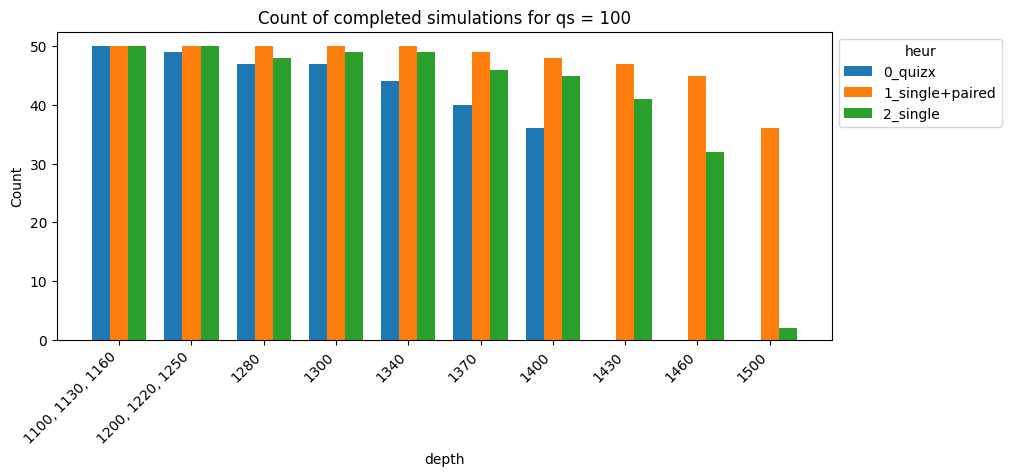

In [36]:
import matplotlib.pyplot as plt


# Filter the DataFrame for a particular value of qs
qs_value = 100
filtered_df = timeout_df.copy()
if qs_value is not None:
    if type(qs_value) == int:
        filtered_df = timeout_df[timeout_df['qs'] == qs_value]
    else:
        filtered_df = timeout_df[timeout_df['qs'].isin(qs_value)]

# Group by 'depth' and 'heur' and count the number of rows
groupby_count = 'depth' if "depth" in filtered_df.columns else 'qs'
    

heur_counts = filtered_df.groupby([groupby_count, feat_name]).size().unstack(fill_value=0)    
# grouped = heur_counts.groupby([groupby_count, feat_name]).agg({
#     'index': lambda x: list(x),
#     MAIN_DATA: 'sum',  # Replace 'some_column' with the actual column to sum
#     OG_DATA: 'sum'  # Replace 'some_column' with the actual column to sum
# }).reset_index()

# l = filtered_df.groupby([groupby_count, feat_name])
# print(heur_counts.columns)


# print(filtered_df.groupby([groupby_count, feat_name]))
# print(heur_counts.index.names)
# lowest_feat = heur_counts.sum(axis=1).idxmin()

# print(heur_counts.sum(axis=0))
# Identify consecutive duplicates in the percentage DataFrame
consecutive_duplicates = []
prev_row = None

new_df = []
indices = []

for idx, row in heur_counts.iterrows():
    if circ == "ccz":
        idx *= 10
    elif circ == "hs":
        idx *= 2
    if prev_row is not None and row.equals(prev_row):
        consecutive_duplicates.append(idx)
        indices[-1].append(idx)
    else:
        new_df.append(row)
        indices.append([idx])
    prev_row = row

new_df = pd.DataFrame(new_df)
new_df['indices'] = indices
# Normalize the counts to get percentages
heur_counts_percentage = heur_counts.div(heur_counts.sum(axis=1), axis=0) * 100



print(heur_counts_percentage.head())

aggregated_indices = new_df
aggregated_indices['indices'] = aggregated_indices['indices'].apply(
    lambda x: f'{x[0]}-{x[-1]}' if len(x) > 3 else ', '.join(map(str, x))
)

x_values = aggregated_indices['indices']


index = range(len(x_values))

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 4))

# Define the width of the bars
bar_width = 1 / (len(filtered_df[feat_name].unique()) + 1)


feat_names = filtered_df[feat_name].unique()

for (j, feat), color in zip(enumerate(feat_names), colors):
    bar = aggregated_indices[feat]
    ax.bar([i + (j + (1 - feat_names.size) / 2) * bar_width for i in index], bar, bar_width, label=feat, color=color)
# Define the positions of the bars
# bar1 = aggregated_indices[MAIN_DATA]
# bar2 = aggregated_indices[OG_DATA]

# # Plot the bars
# ax.bar([i - bar_width * (len(feat_names) - 1) / 2 for i in index], bar1, bar_width, label=MAIN_DATA, color='blue')
# ax.bar([i + bar_width * (len(feat_names) - 1) / 2 for i in index], bar2, bar_width, label=OG_DATA, color='orange')

# Adding labels and title
x_label = groupby_count if circ != "hs" else "ccz"
ax.set_xlabel(x_label)
ax.set_ylabel('Count')
suffix = f" for qs = {qs_value}" if qs_value else ""
ax.set_title(f'Count of completed simulations{suffix}')
ax.set_xticks([i for i in range(len(x_values))])
if len(x_values) >= 10:
    ax.set_xticklabels(x_values, rotation=45, ha='right')
else:
    ax.set_xticklabels(x_values)
ax.legend(title=feat_name, bbox_to_anchor=(1, 1))

# Display the plot
plt.show()